<a href="https://colab.research.google.com/github/Abhishekjain113/covid-19-densenet/blob/main/googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os

#required libraries
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras.models import Sequential
from tensorflow.keras.layers import concatenate


In [3]:
disease_types=['COVID', 'non-COVID']
data_dir = '//content/drive/MyDrive/Dataset'
train_dir = os.path.join(data_dir)
print(train_dir)

//content/drive/MyDrive/Dataset


In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (100).png,0,COVID
1,COVID/Covid (1038).png,0,COVID
2,COVID/Covid (1035).png,0,COVID
3,COVID/Covid (1007).png,0,COVID
4,COVID/Covid (1029).png,0,COVID


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (606).png,0,COVID
1,non-COVID/Non-Covid (566).png,1,non-COVID
2,COVID/Covid (1226).png,0,COVID
3,non-COVID/Non-Covid (757).png,1,non-COVID
4,non-COVID/Non-Covid (1002).png,1,non-COVID


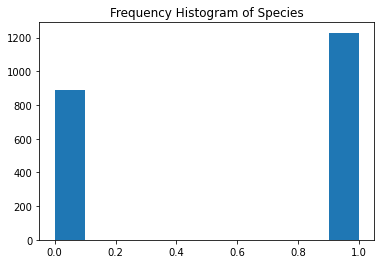

<Figure size 864x864 with 0 Axes>

In [6]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

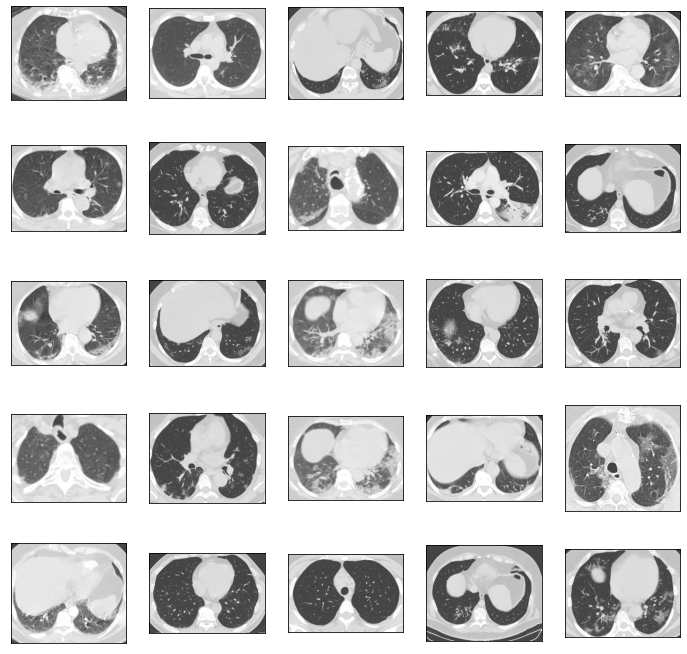

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

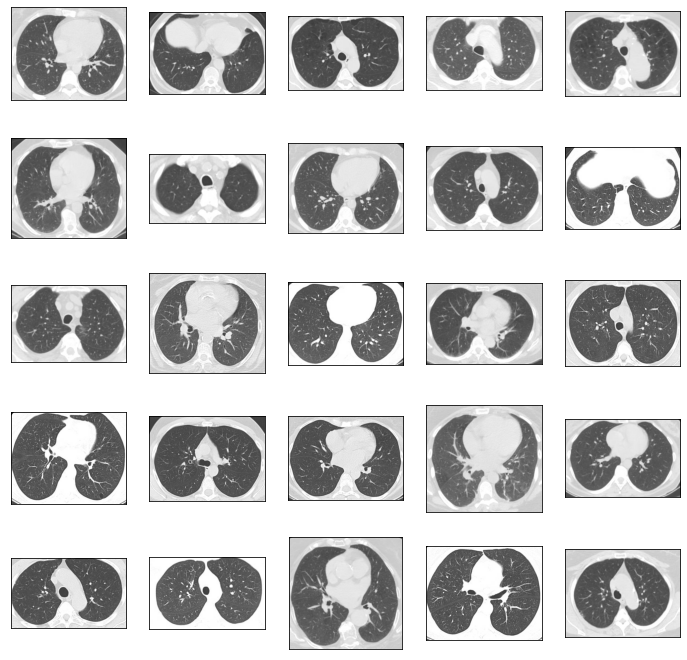

In [8]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

In [9]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2120it [08:17,  4.26it/s]


Train Shape: (2120, 224, 224, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)


In [12]:

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D

def inception_module(x, filters):
    branch1x1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)
    
    branch3x3 = Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    branch3x3 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(branch3x3)
    
    branch5x5 = Conv2D(filters=filters[3], kernel_size=1, activation='relu')(x)
    branch5x5 = Conv2D(filters=filters[4], kernel_size=5, padding='same', activation='relu')(branch5x5)
    
    branch_pool = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv2D(filters=filters[5], kernel_size=1, activation='relu')(branch_pool)
    
    output = Concatenate()([branch1x1, branch3x3, branch5x5, branch_pool])
    
    return output

input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

# initial conv layer
x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# first inception module
x = inception_module(x, filters=[64, 96, 128, 16, 32, 32])

# second inception module
x = inception_module(x, filters=[128, 128, 192, 32, 96, 64])
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# third inception module
x = inception_module(x, filters=[192, 96, 208, 16, 48, 64])

# fourth inception module
x = inception_module(x, filters=[160, 112, 224, 24, 64, 64])
x = inception_module(x, filters=[128, 128, 256, 24, 64, 64])
x = inception_module(x, filters=[112, 144, 288, 32, 64, 64])

# fifth inception module
x = inception_module(x, filters=[256, 160, 320, 32, 128, 128])
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# global average pooling
x = AveragePooling2D(pool_size=7, strides=7, padding='same')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

# final output layer for binary classification
output_layer = Dense(units=2, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
from tensorflow.keras.optimizers import SGD
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])


In [18]:

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation


In [19]:
# Fit the model to the training data, using the validation data for validation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=50,
               verbose=2,
               validation_data=(X_val, Y_val))

Epoch 1/50
26/26 - 33s - loss: 0.6830 - accuracy: 0.5925 - val_loss: 0.6937 - val_accuracy: 0.5542 - 33s/epoch - 1s/step
Epoch 2/50
26/26 - 14s - loss: 0.6694 - accuracy: 0.6118 - val_loss: 0.6934 - val_accuracy: 0.5542 - 14s/epoch - 530ms/step
Epoch 3/50
26/26 - 13s - loss: 0.6809 - accuracy: 0.5745 - val_loss: 0.6859 - val_accuracy: 0.5542 - 13s/epoch - 499ms/step
Epoch 4/50
26/26 - 13s - loss: 0.6721 - accuracy: 0.6118 - val_loss: 0.6932 - val_accuracy: 0.5542 - 13s/epoch - 503ms/step
Epoch 5/50
26/26 - 13s - loss: 0.6843 - accuracy: 0.5685 - val_loss: 0.6864 - val_accuracy: 0.5542 - 13s/epoch - 504ms/step
Epoch 6/50
26/26 - 13s - loss: 0.6816 - accuracy: 0.5781 - val_loss: 0.6878 - val_accuracy: 0.5542 - 13s/epoch - 502ms/step
Epoch 7/50
26/26 - 13s - loss: 0.6770 - accuracy: 0.5877 - val_loss: 0.6875 - val_accuracy: 0.5542 - 13s/epoch - 498ms/step
Epoch 8/50
26/26 - 13s - loss: 0.6742 - accuracy: 0.5925 - val_loss: 0.6898 - val_accuracy: 0.5542 - 13s/epoch - 504ms/step
Epoch 9/50


In [20]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

14/14 [==============================] - 1s 76ms/step - loss: 0.5066 - accuracy: 0.7429
Final Loss: 0.506635844707489, Final Accuracy: 0.7429245114326477


14/14 [==============================] - 1s 69ms/step


Text(0.5, 145.31999999999996, 'Predicted')

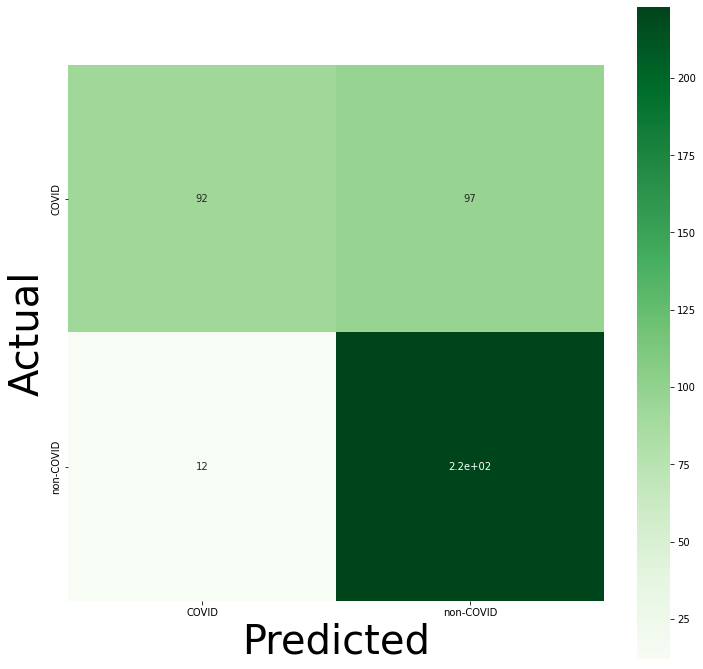

In [21]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

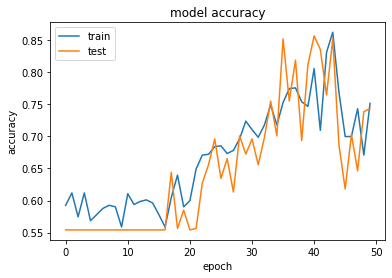

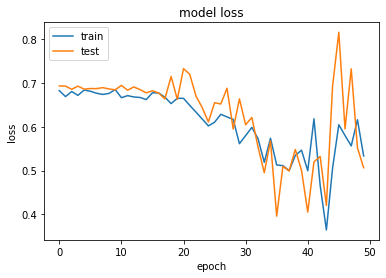

In [22]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 637ms/step
[0.86367744 0.13735008]


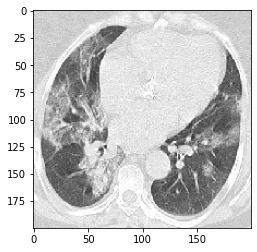

Prediction: Covid-19


In [23]:
from skimage import io
#path='imbalanced/Scratch/Scratch_400.jpg'
import keras.utils as image

img = image.load_img('//content/drive/MyDrive/Dataset/COVID/Covid (1010).png', grayscale=False, target_size=(224, 224))
show_img=image.load_img('//content/drive/MyDrive/Dataset/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])